## The very very basics of ML. With R.

Experiment freely. This is a hands-on (alias brains off) experience!

In [16]:
options(warn=-1, error = expression(NULL))

Prior beginning, source all the required dependencies.

In [18]:
source('../../src/lib.R')

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Just in case you were wondering what you can do with CARET. Here you have 232 pre-implemented and ready_to_go ML algorithms right at your fingertips

In [86]:
## get availlable models

info = getModelInfo()
info %>% names %>% as_data_frame %>% head(5)

value
ada
AdaBag
AdaBoost.M1
adaboost
amdai


Also, get the data and have a look

In [78]:
df = get_partitioned_df()

df$full %>% head

x,y,class,type
0.0009125974,0.3722474,class_2,normal
0.1942694555,0.1480679,class_2,normal
0.2750015332,0.3793457,class_2,normal
0.9859239661,0.7900648,class_1,normal
0.3594508445,0.3582799,class_2,normal
0.2318551183,0.4590775,class_2,normal


We will now be working with the "spiral" dataset, but you can actually choose from a bunch of them:

In [79]:
get_full_dataset() %>% select('type') %>% unique

type
normal
circles
spirals
linear


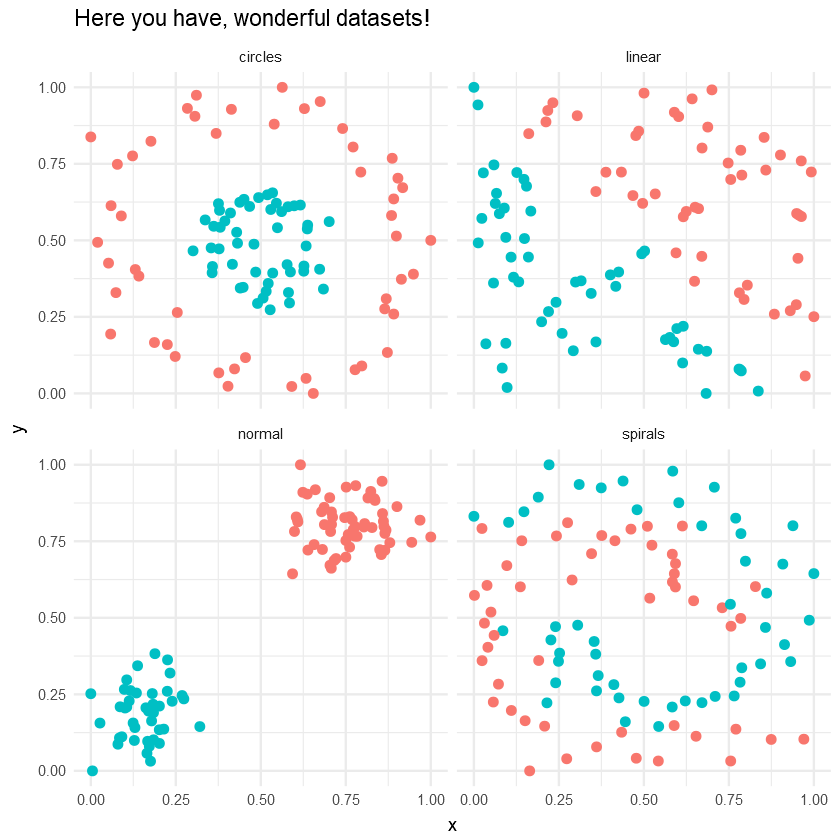

In [76]:
## plot all the datasets

get_full_dataset()  %>% ggplot(aes(x = x, y = y, color = class)) +
  geom_point(size = 2) + theme_minimal()  +
  ggtitle('Here you have, wonderful datasets!') +
  theme(legend.position = "none") +
  facet_wrap(~type)

## K Nearest Neighbours

Just for refreshing your short term memory, this is what KNN at its simplest looks like:

$$ \Pr(Y = j | X = x_0) = \frac{1}{K}\sum_{k \in N_0}{I(y_k = j)}$$

Which basically means that the probability of an observation $x_0$ to belong to class $j$, is the the weighed sum of the "votes" given by the *k* closest point of class $j$. That said, the more observations among $N_0$ (the closest *k*'s) belongs to the class $j$ the most likely is for $x_0$ to belong to class $x_0$ as well.

In [87]:
## choose the dataset

data_name = 'spirals'

## choose the algorithm

algorithm = 'knn'

## set the hyperparameter

k = 10

hyperparameters = data.frame('k' = k)

In [88]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
              x = df[[data_name]]$x_train,
              method = algorithm,
              tuneGrid = hyperparameters,
              trControl = trainControl(classProbs =  TRUE)
)

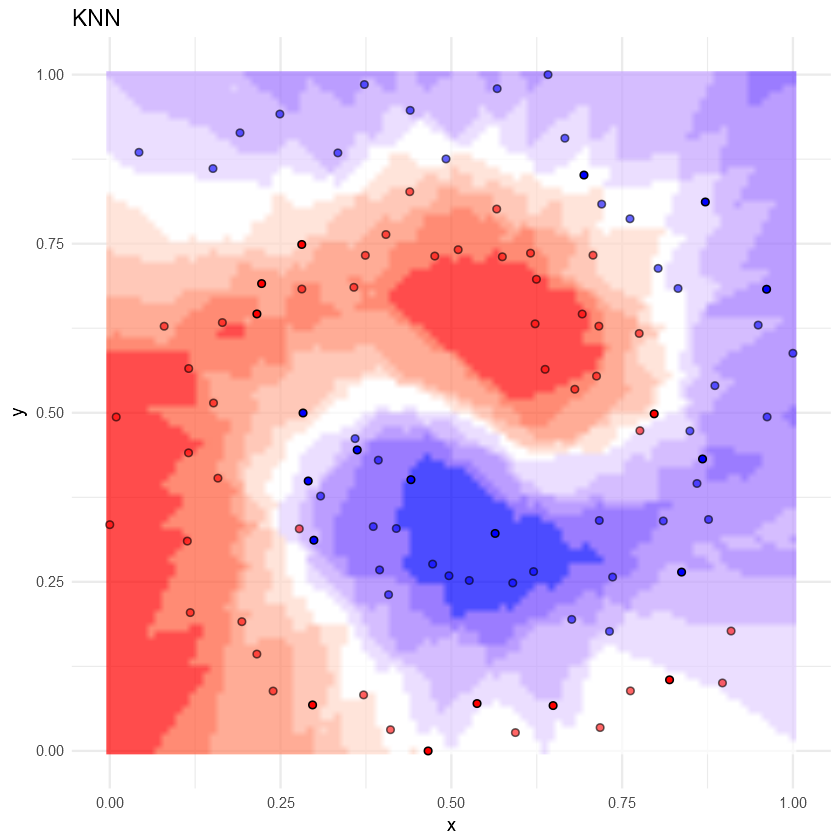

In [90]:
  ### prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")

Pretty neat, isn't it? Well, a close look tells that there are some red points in the bottom right corner that are classified as in the blue zone. This is not good. What can you do?

### Tweak SVM Hyperparameters

In [92]:
# set the hyperparameter

k = 5

hyperparameters = data.frame('k' = k)

In [94]:
model = train(y = df[[data_name]]$y_train$class,
              x = df[[data_name]]$x_train,
              method = algorithm,
              tuneGrid = hyperparameters,
              trControl = trainControl(classProbs =  TRUE)
)

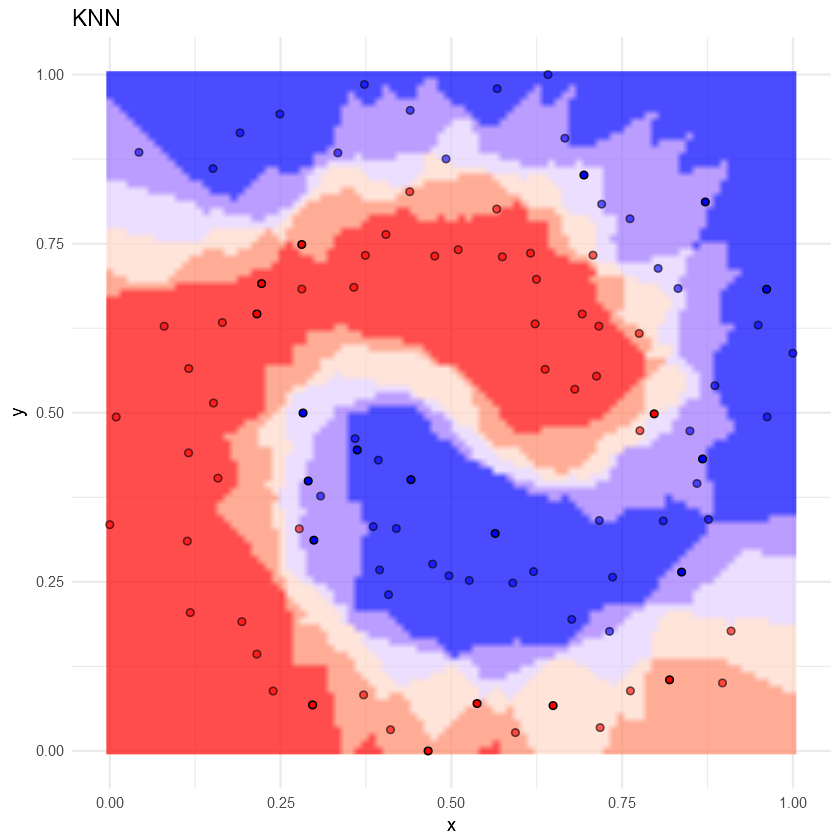

In [95]:
  ### prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")

That's way better! Can you see how the model is now much more confident on the position of the observations in the bottom right corner?

## Spoiler alert: the **kernel trick** (for KNN) + a few things about distances

You will see that Support Vector Machine projects the feature in a higer-dimensional space in order to fit the best-feature separating hyperplane. Despite principles of SVM being radically different from those of SVM, the *kernel trick* can be beneficial with KNN as well, whenever features are to much entangled to be neatly separated. 

Also, for now we have just mentioned euclidean distance between points, but in different settings a different measure of distance may turn out being more effective. *Minkowski* distance is generalize the concept of distance.

To manipulate both the *kernel trick* and the *Minkowski* in the hyperparameter setting phase, you shall use a different implementation of the knn algorith, which is anyway availlable in CARET

In [129]:
## choose the ML algorithm

algorithm = 'kknn' # alias KERNEL KNN

info[[algorithm]]$parameters

parameter,class,label
kmax,numeric,Max. #Neighbors
distance,numeric,Distance
kernel,character,Kernel


In [144]:
k = 10

hyperparameters = data.frame('kmax' = 5,
                             'distance' = 0.1,   # coefficent p of the Minkowski distance. Set to two reduces to euclidean distance.
                             'kernel' = c('epanechnikov') # rectangular is the equivalent of polinomial kernel in SVM
                            )

In [145]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
              x = df[[data_name]]$x_train,
              method = algorithm,
              tuneGrid = hyperparameters,
              trControl = trainControl(classProbs =  TRUE)
)

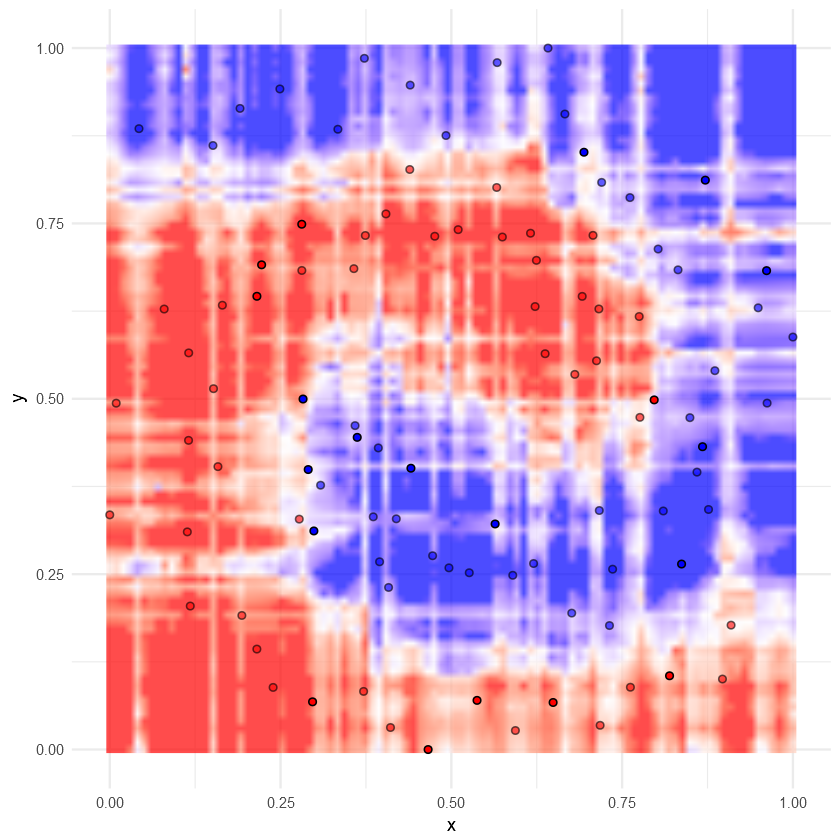

In [146]:
## prepare prediction

from <- 0
to <- 1
n <- 100
grid_df <- expand.grid(
  x = seq(from, to, length.out = n),
  y = seq(from, to, length.out = n)
)

grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)

## Prepare plot dataset

data_df <- lapply(
  data_name,
  function(data_name) {
    df <- df[[data_name]] 
    rbind(
      df$full_train %>% mutate(partition = "train"),
      df$full_val %>% mutate(partition = "val")
    )
  }
) %>% bind_rows

## plot data
ggplot() + 
  geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
  scale_fill_gradient2(low = "blue", mid = "white",
                       high = "red", midpoint = 0.5, space = "rgb",
                       na.value = "grey50", guide = "colourbar") +
  geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
  scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
  theme_minimal() +
  theme(legend.position = "none")

Whoops! Any better? Perhaps, but this looks like overfitting to me. Indeed, in our extremely simplified setting (generated data and only two fratures), both the kernel trick and non euclidean distances are not quite necessary.

Try instead furthe reducing the nmners of k neigbouus... #simpleisbetter

Anyway, let's try something else.

## Support Vector Machines

Just as a reminder, a SVM tries finding a best separating hyperplane in a d-dimensional kernel space.

Quite (much) naively, a properly trained SVM mode draws a good separating line between points of different classes.

We start out with the the **polinomial kernel**:

$$f(x) = \beta_0 +  \sum_{i \in S}\alpha_iK(x_i, x_{i'})$$
where:

* $S$ is the number of support vectors (i.e. points in the d-dimensional hyperspace)

* $\beta_0$ is the *offset* parameter ( = 0 in the implementation of svmPoly)

* $\alpha_i$ is the *scale* parameter 

* $K(x_i, x_{i'}) = (1+\sum_{j=1}^{p}x_{ij}x_{i'j})^d$ is the *polinomial kernel*

In [77]:
## choose the algorithm

algorithm = 'svmPoly'

info = getModelInfo()
info[[algorithm]]$parameters

## set the hyperparameters

degree = 1
scale = 1
cost = 1

hyperparameters = data.frame('degree' = degree,
                             'scale' = scale,
                             'C' = cost)

parameter,class,label
degree,numeric,Polynomial Degree
scale,numeric,Scale
C,numeric,Cost


C is the *cost* parameter: the higher, the lower the tolerance of misclassified points. This does not belong to the model itself but it a useful workaround to determine a trade off between variance (ability to correctly deal with outliers) and bias of the final model (ability to correcly discriminate between classes). If set too high, it may result in overfitting the data, conversely into bad predictions.

#TODO add citation for the pic below

![A support vector classifier was fit using four different values of the tuning parameter C . The largest value of C was used in the top left panel, and smaller values were used in the top right, bottom left, and bottom right panels. When C is large, then there is a high tolerance for observations being on the wrong side of the margin, and so the margin will be large. As C decreases, the tolerance for observations being on the wrong side of the margin decreases, and the margin narrows.](../fig/cost_parameter_svm.png)

In [23]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot',
                                    classProbs =  TRUE)
           )

Warning message:
"Setting row names on a tibble is deprecated."

maximum number of iterations reached 0.0001762931 -0.0001762622

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

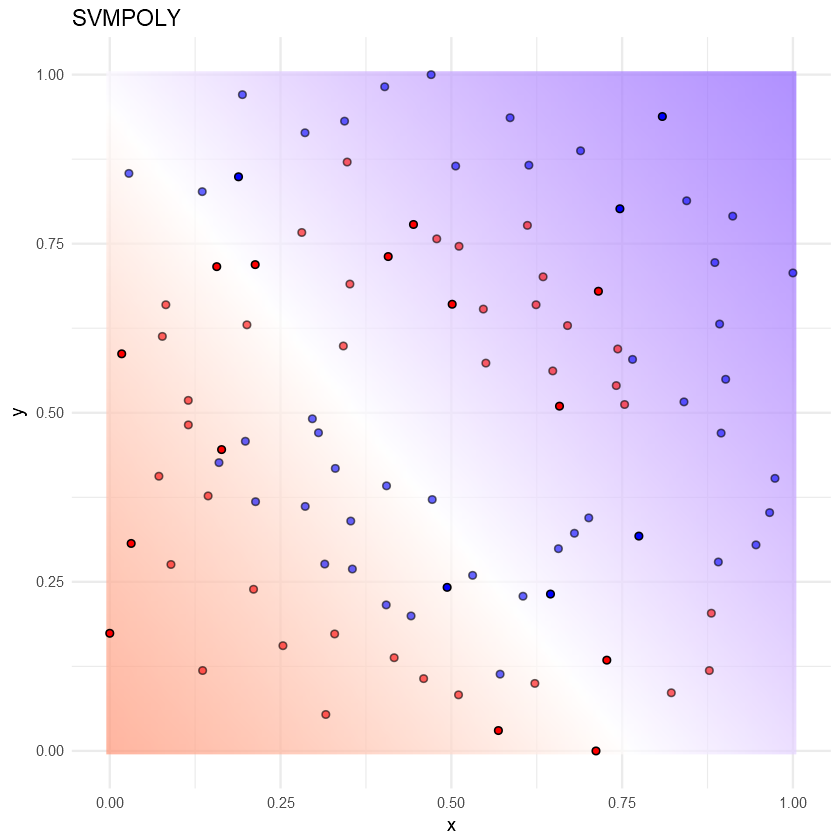

In [27]:
  ### prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")

Pretty bad, don't you think? This is because we set a 1-degree polinomial kernel. With this approach, the SVM degenerates to a simpler Support Vector *Classifier*, which is much less powerful. 

### Tweak SVM Hyperparameters

Let's profit of the *kernel trick* and try changing some hyperparatemer.

In [29]:
## set the hyperparameters

degree = 3
scale = 0.33
cost = 3

hyperparameters = data.frame('degree' = degree,
                             'scale' = scale,
                             'C' = cost)

In [31]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot',
                                    classProbs =  TRUE)
           )

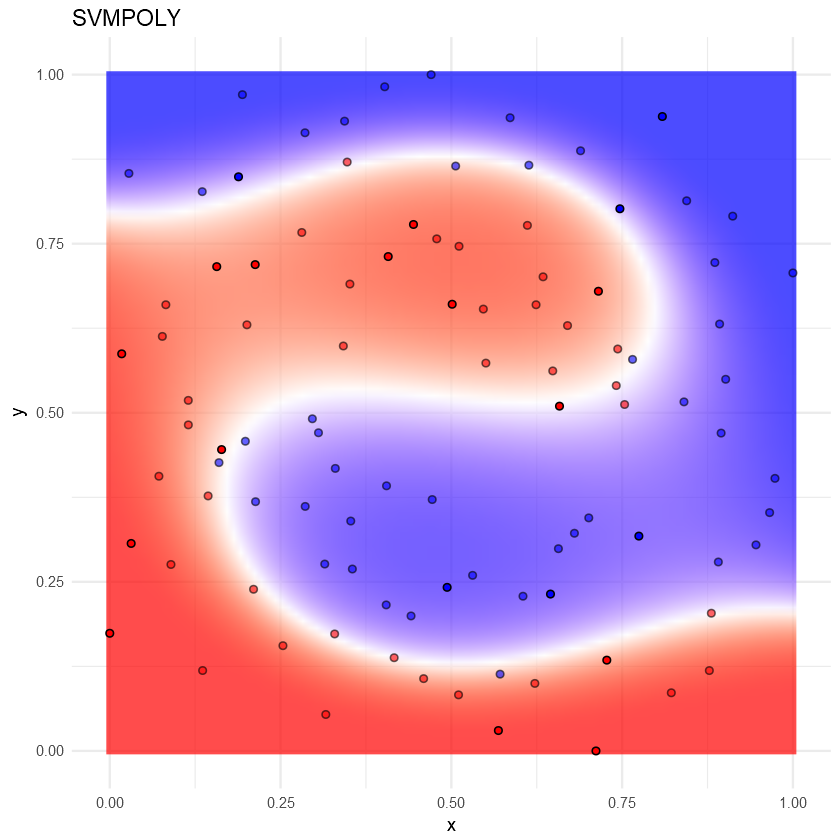

In [33]:
  ## prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")


Now change kernel type and go for a **radial kernel**:

$$K(x_i, x_{i'}) = \exp\big(-\gamma \sum_{j=1}^{p}(x_{ij}-x_{i'j})^2\big)$$

where:

* $\gamma$ is the *scale* parameter, which set the speed of the exponential decay
* this kernel function is suspiciously similar to the KNN framework...

In [34]:
algorithm = 'svmRadial'

info[[algorithm]]$parameters

parameter,class,label
sigma,numeric,Sigma
C,numeric,Cost


Cost has the same interpretation as of above.

In [37]:
model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           trControl = trainControl(method = 'boot',
                                    classProbs =  TRUE)
           )

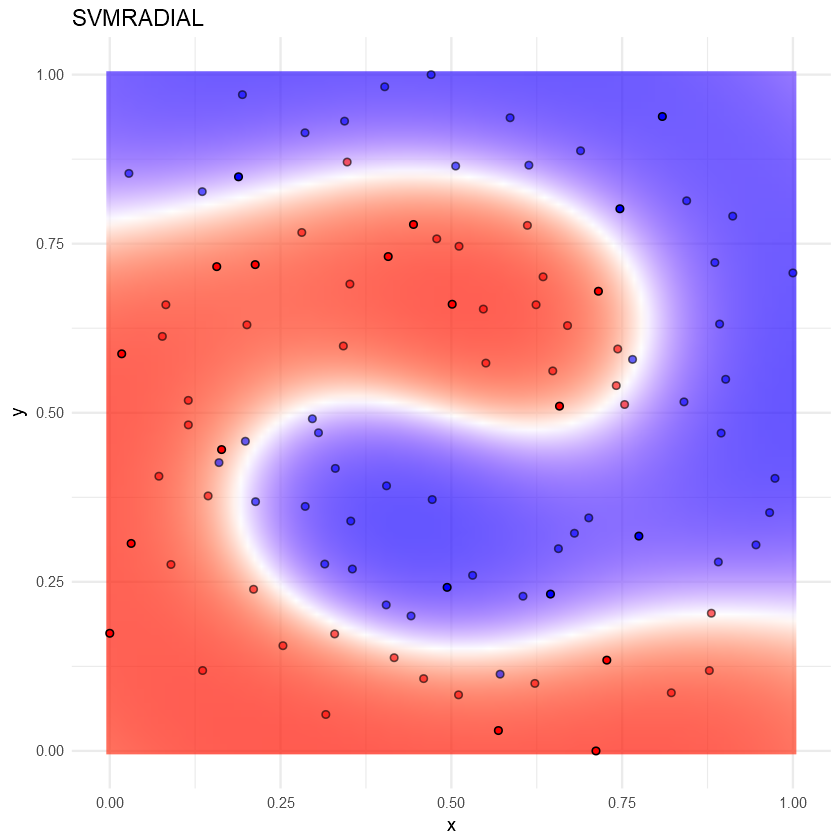

In [39]:
 ### prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")


## Decision Trees

Again, to brief. ONe of the most reknowned DT algorithm is called ID3: Iterative Dichotomizer. Allo other are pretty similar. 

In a nutshell, ID3 repeatedt partition the data across the feature in an attempt to discriminate the classes. The partitioning is performen based on an Information Gain $IG$ principle, a criterion based on a measure of entropy $H$ in the dataset or in its partitions $S$.
The partitioning recursively happens for every branch until
* the information gain from a further partitioning is too low;
* all the istances $x$ in a partition belongs to the same class $Y$;
* a pre-defined number of iteration is reached.

Notably:

* Entropy: $H(S) = \sum_{x \in Y} -p(y) \log_{2}p(y)$

* Information Gain: $IG(A,S) = H(S) - \sum_{t \in T} p(t)H(t)$

Where:
* $H(S)$ – Entropy of set $S$
* $T$ – The subsets created from splitting set $S$ by attribute $A$ such that $S = \bigcup_{t \in T} t$
*$p(t)$ – The proportion of the number of elements in $t$ to the number of elements in set $S$
* $H(t)$ – Entropy of subset $t$

In [102]:
## choose the algorithm

algorithm = 'rpart2'

info[[algorithm]]$parameters

parameter,class,label
maxdepth,numeric,Max Tree Depth


In [ ]:
## set the hyperparameters

maxdepth = 1

hyperparameters = data.frame('maxdepth' = maxdepth)

In [103]:
model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot')
           )

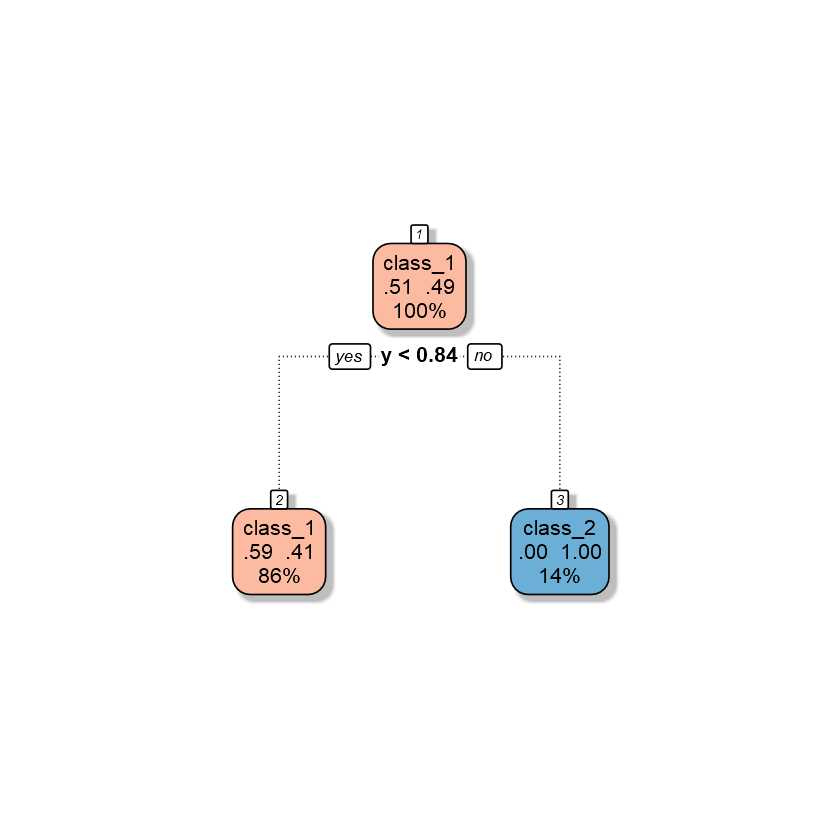

In [99]:
## plot splitting iterations

fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

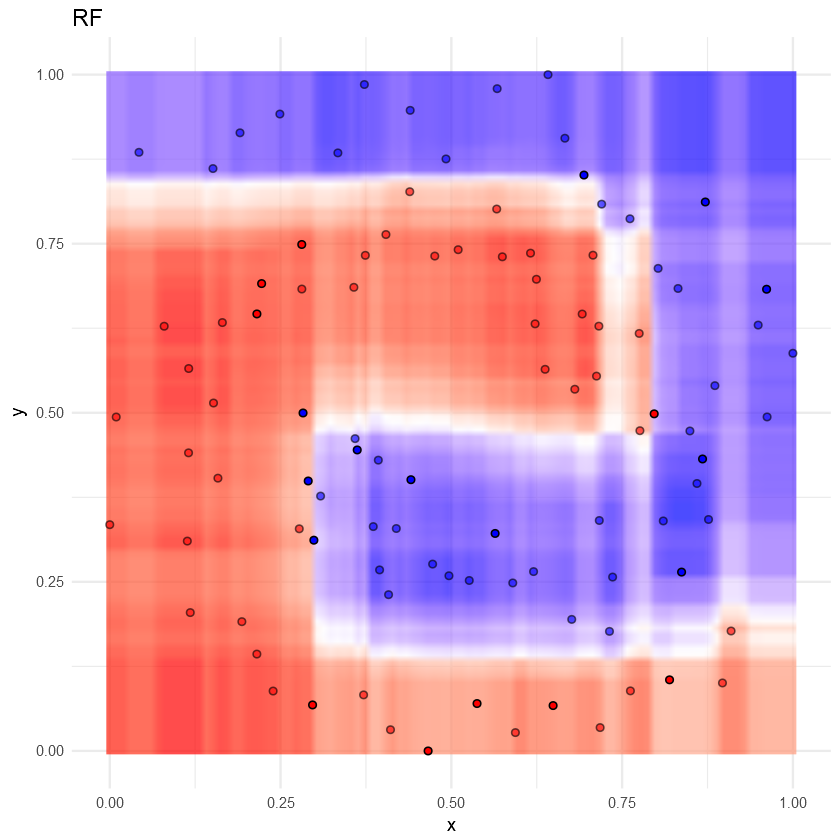

In [124]:
  ### prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")


### Tweak DT Hyperparameters

In [112]:
## set the hyperparameters

maxdepth = seq_len(10)

hyperparameters = data.frame('maxdepth' = maxdepth)

In [113]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot')
           )

We cannot really set the exact value of the tree lenght, which is indeed determined by
* the information gain
* the residual entropy

therefore, the ML algorithm iteratively tries different solytions and select the best one. What does it mean *the best one*? Food for thoughts, for next session!

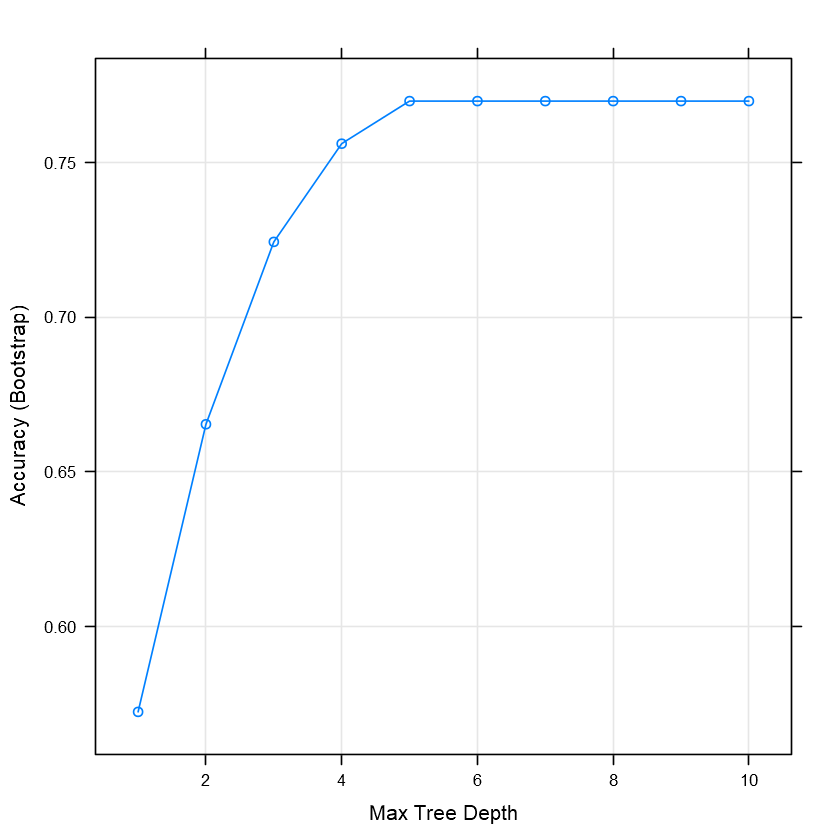

In [115]:
plot(model)

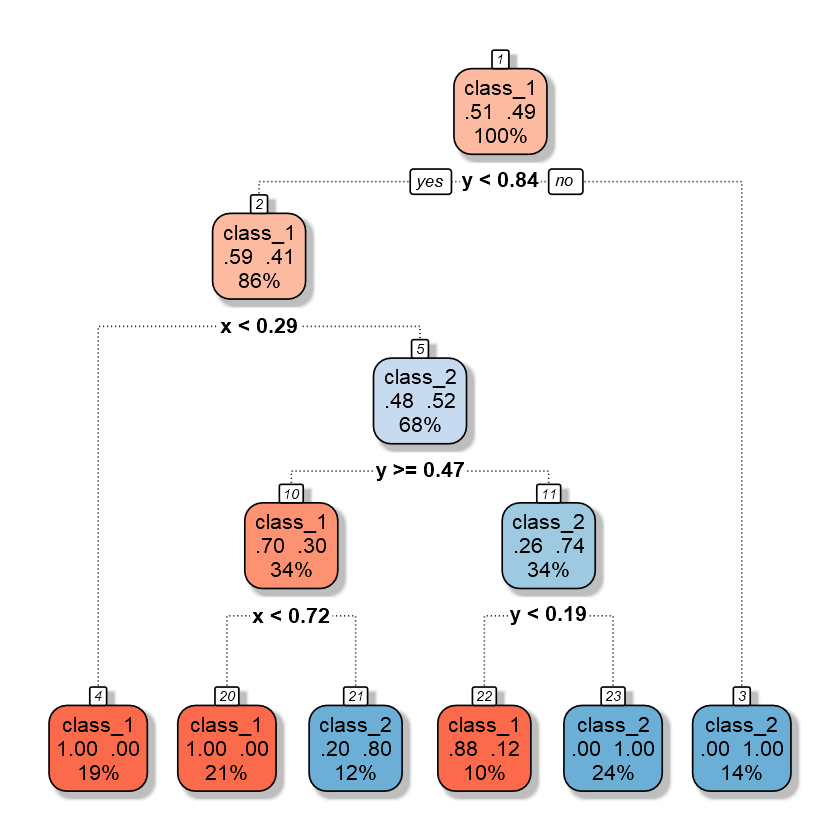

In [116]:
## plot splitting iterations

fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

This looks neat!

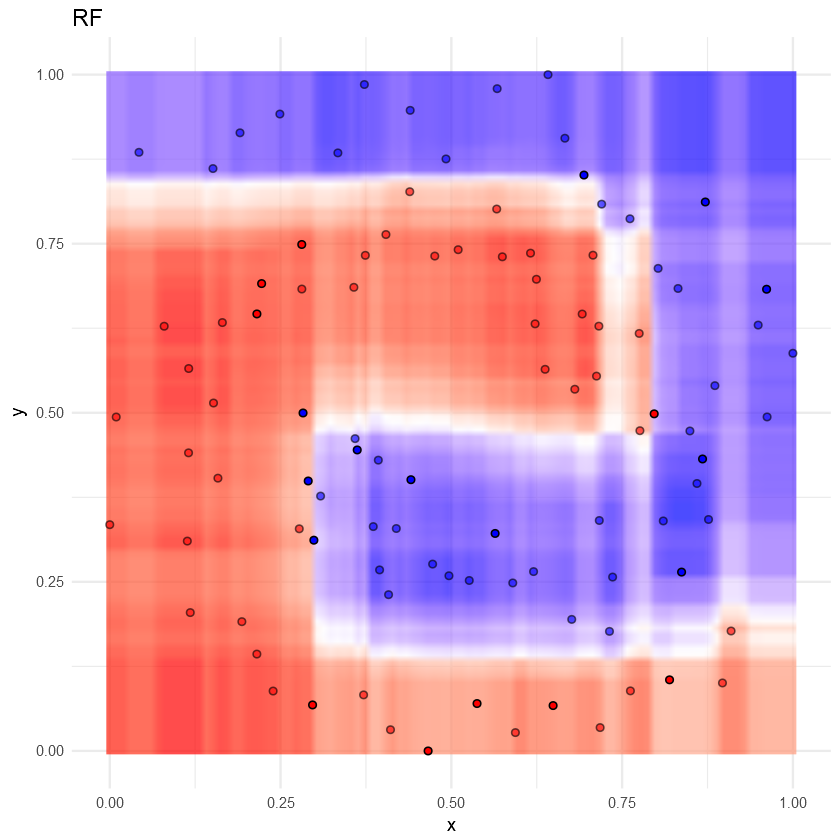

In [125]:
 ### prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")


## Random Forests

They are a quite natural extension of decision trees. They aim in solving some overfitting problem of classic decision trees.

Basically a RF is a bunch of DT whose features are randomly selected across the feature space of the dataset. In our case it is not too much of a problem, as we just have two features, but in a more complex setting this approach can really make the difference.

In [119]:
## choose the algorithm

algorithm = 'rf'
  
info[[algorithm]]$parameters
  
## set the hyperparameter

mtry = 1
  
hyperparameters = data.frame('mtry' = mtry)

parameter,class,label
mtry,numeric,#Randomly Selected Predictors


In [120]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
                x = df[[data_name]]$x_train,
                method = algorithm,
                tuneGrid = hyperparameters,
                trControl = trainControl(method = 'boot')
  )

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



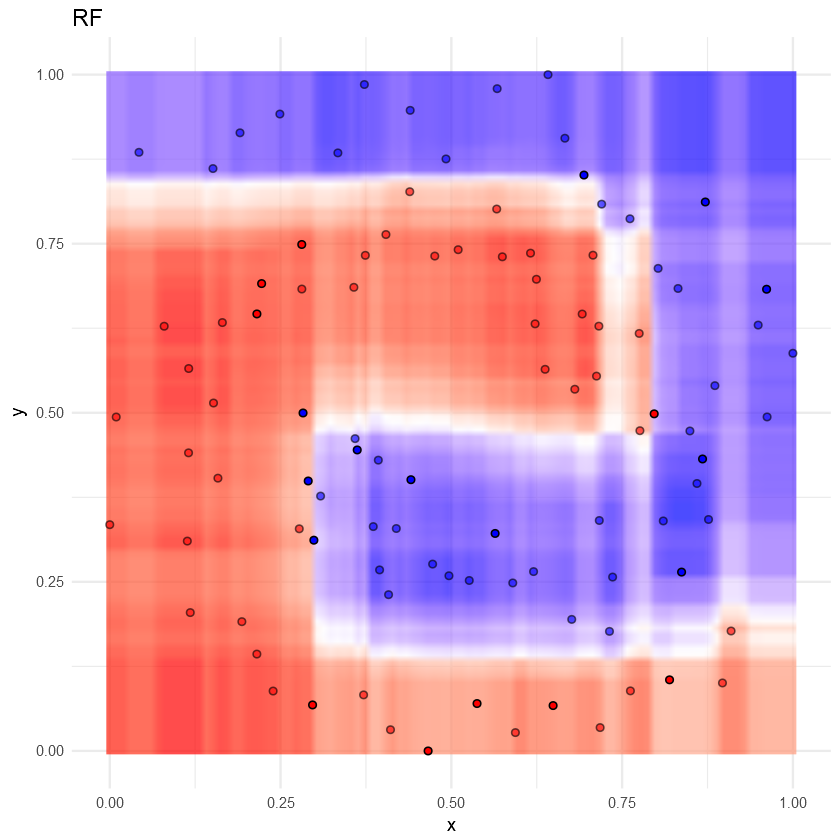

In [126]:
  ## prepare prediction

  from <- 0
  to <- 1
  n <- 100
  grid_df <- expand.grid(
    x = seq(from, to, length.out = n),
    y = seq(from, to, length.out = n)
  )
  
  grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)
  
  ## Prepare plot dataset
  
  data_df <- lapply(
    data_name,
    function(data_name) {
      df <- df[[data_name]] 
      rbind(
        df$full_train %>% mutate(partition = "train"),
        df$full_val %>% mutate(partition = "val")
      )
    }
  ) %>% bind_rows
  
  ## plot data
  ggplot() + 
    geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
    scale_fill_gradient2(low = "blue", mid = "white",
                         high = "red", midpoint = 0.5, space = "rgb",
                         na.value = "grey50", guide = "colourbar") +
    geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
    scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
    theme_minimal() + ggtitle(model$method %>% toupper) +
    theme(legend.position = "none")
